In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # python library for Regular Expressions
# import sql libraries
# a hack to print all my cell outputs / change 'all' to 'last_expr' to revert to default
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [79]:
# load in the data
restaurants_yelp_df = pd.read_csv('../data/yelp_restaurant_df.csv')
restaurants_foursquares_df = pd.read_csv('../data/foursquares_restaurant_df.csv')
rentals_yelp_df = pd.read_csv('../data/yelp_car_rentals_df.csv')
rentals_foursquares_df = pd.read_csv('../data/foursquares_car_rentals_df.csv')
stations_df = pd.read_csv('../data/stations_df.csv')

In [80]:
rentals_foursquares_df.head()
rentals_yelp_df.head()

,Name,Bike Station Id,Category
0,Avis Rent A Car,0,['Rental Car Location']
1,Budget Truck Rental,0,['Rental Car Location']
2,Advantage Rent A Car,0,['Rental Car Location']
3,Enterprise Rent-A-Car,0,['Rental Car Location']
4,Flight Car,0,['Rental Car Location']


,Name,Review Count,Ratings,Bike Station Id,Category
0,National Car Rental,84,3.5,1,['carrental']
1,Rental Car Center Boston,1,3.0,1,['carrental']
2,Avis Car Rental,240,1.5,1,['carrental']
3,Thrifty Car Rental,201,1.5,1,['carrental']
4,Advantage Rental Cars,117,1.0,1,['carrental']


# Join the data from Part 1 with the data from Part 2 to create a new dataframe.

This will be done in 3 stages:

1. Using `.concat()` to merge the 2 Restaurant dataframes (from Yelp and FourSquares), and the 2 Rentals dataframes (from Yelp and FourSquares) into one restaurants_df and rentals_df respectively.
    - Cleaning the dataframes - removing duplicates, fixing missing data, etc.
1. Merging the restaurants_df and rentals_df into the final `points_of_interest_df`  with `.concat()`
2. Merging the `points_of_interest_df` with the citybikes `stations_df` with `.merge()`

### 1. Creating the `restaurants_df` and `rentals_df`

**Further Data Cleaning for the Database**:

1. Simplify the `Category` columns to just `Restaurant` or `Car Rentals`.

2. Fill the missing values of `Reviews` with the average Review for that Category.

3. Fill the missing values of `Ratings` with the minimum Ratings in that Category.

In [81]:
# dropping the Category columns
for df in [restaurants_yelp_df, 
           restaurants_foursquares_df,
           rentals_yelp_df,
           rentals_foursquares_df]:
    df.drop(columns = 'Category', inplace=True)

# Concatenating the dataframes & adding a simpler Category column
rentals_df = pd.concat([rentals_yelp_df, rentals_foursquares_df])
rentals_df['Category'] = 'Car Rental'
restaurants_df = pd.concat([restaurants_yelp_df, restaurants_foursquares_df])
restaurants_df['Category'] = 'Restaurant'

### Handling Duplicates: Cleaning the Names columns

Quick inspection on Excel spreadsheet shows that many names of the businesses appear to be duplicates (`Avis Rental Car` vs `Avis Car Rental` vs `Avis CarRental` vs `Avis's Car Rental` which are all listed as unique values.

I used the Python Regex library and some string formatting techniques to do some quick data cleaning...

In [82]:
def simplify(Name):
    '''
    Argument: LIST of sentence strings usually representing a column of names in a dataframe
    simplifies the names
    returns: a LIST of strings of the same length
    be mindful of python strings and copying traps
    '''
    Names = Name.copy()
    # dictionary of non-exhaustive replacement words
    dictionary = {
    '/':" ",
    'grille': 'grill',
    'caf' : 'cafe',
    'cafee': 'cafe',
    'coffee': 'cafe',
    '&': 'and',
    '  ': ' ',
    '’' : "'",
    'cars': 'car',
    'carrental' : 'car rental',
    'rental car': 'car rental',
    'rent-a-car' : 'car rental',
    'rent a car': 'car rental',
    'rentacar': 'car rental',
    'auto van and truck': 'auto',
    'auto van': 'auto',
    'auto car': 'auto',
    'auto and truck': 'auto',
    'rental van': 'van rental',
    'rental truck': 'truck rental'
    }


    for i, name in enumerate(Names):
        acronmym_check = bool(re.search(r"([A-Z]{3,9})", name)) 
        name = name.encode('ascii', 'ignore').decode('ascii') 
        name = re.sub(r'([a-z])-([a-z])', r'\1\2', name) #removing hyphens
        name = re.sub(r"([a-zA-NP-Z]+)'([a-rt-zA-RT-Z])", r"\1\2", name) # removing middle quotes
        name = re.sub(r"([a-z])([A-Z])", r"\1 \2", name) #irregular smallCapletter combinatons
        name = name.lower()
        for check in  dictionary:
            name = name.replace(check, dictionary[check])
        if acronmym_check:
            name = name.upper() # don't capitalize acronyms
        else:
            name = name.title()
        name = name.replace("'S", "'s")
        Names[i] = name
    return Names

In [83]:
# check unique names before calling the function
rentals_df['Name'].nunique()
Names = list(rentals_df['Name'].copy()) # must copy it into a separate list variable first
NewNames = simplify(Names)
rentals_df.loc[:, 'Name'] = NewNames # assign with .loc
rentals_df['Name'].nunique() # check unique names again after function
# 156 to 150 last run

156

150

In [84]:
# check unique names before calling the function
restaurants_df['Name'].nunique()
Names = list(restaurants_df['Name'].copy()) # must copy it into a separate list variable first
NewNames = simplify(Names)
restaurants_df.loc[:, 'Name'] = NewNames # assign with .loc
restaurants_df['Name'].nunique() # check unique names again after function
# 4054 to 4002

4054

4002

In [85]:
# Spot check before removing duplicates
rentals_df.info()
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436 entries, 0 to 3038
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3436 non-null   object 
 1   Review Count     397 non-null    float64
 2   Ratings          397 non-null    float64
 3   Bike Station Id  3436 non-null   int64  
 4   Category         3436 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 161.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27745 entries, 0 to 18994
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             27745 non-null  object 
 1   Review Count     8750 non-null   float64
 2   Ratings          8750 non-null   float64
 3   Bike Station Id  27745 non-null  int64  
 4   Category         27745 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [88]:
# Dropping duplicated data, keeping the rows from the Yelp dataframe because they have more information
rentals_df.drop_duplicates(subset=['Name', 'Bike Station Id'], keep='first', inplace=True, ignore_index=True)
rentals_df.info()

restaurants_df.drop_duplicates(subset=['Name', 'Bike Station Id'], keep='first', inplace=True, ignore_index=True)
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3138 non-null   object 
 1   Review Count     397 non-null    float64
 2   Ratings          397 non-null    float64
 3   Bike Station Id  3138 non-null   int64  
 4   Category         3138 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 122.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072 entries, 0 to 24071
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             24072 non-null  object 
 1   Review Count     8750 non-null   float64
 2   Ratings          8750 non-null   float64
 3   Bike Station Id  24072 non-null  int64  
 4   Category         24072 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 940.4+ KB


**Observation**:

`Null` values of Review Count and Ratings are substantial in Restaurants, and less substantial in Car Rentals. Will replace the value of Rating with the median values of Rating, and the values of Review Count with the minimum value.

In [89]:
### Treating Null values
for df in [restaurants_df, rentals_df]:
    df['Ratings'].fillna(round    ((2* df['Ratings'].median())/2), inplace=True) # rounding to nearest 0.5
    df['Review Count'].fillna(df['Review Count'].min(), inplace=True)
    # converting review count back to integer values
    df['Review Count'] = df['Review Count'].astype(int)

In [90]:
rentals_df.info()
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3138 non-null   object 
 1   Review Count     3138 non-null   int64  
 2   Ratings          3138 non-null   float64
 3   Bike Station Id  3138 non-null   int64  
 4   Category         3138 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 122.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072 entries, 0 to 24071
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             24072 non-null  object 
 1   Review Count     24072 non-null  int64  
 2   Ratings          24072 non-null  float64
 3   Bike Station Id  24072 non-null  int64  
 4   Category         24072 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 940.4+ KB


In [91]:
rentals_df.describe()
restaurants_df.describe()

,Review Count,Ratings,Bike Station Id
count,3138.000000,3138.000000,3138.000000
mean,4.611217,2.055609,208.184194
std,20.106171,0.427030,132.018931
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,88.000000
50%,1.000000,2.000000,201.000000
75%,1.000000,2.000000,316.000000
max,240.000000,5.000000,442.000000


,Review Count,Ratings,Bike Station Id
count,24072.000000,24072.000000,24072.000000
mean,125.592348,3.996178,217.399884
std,374.466490,0.399755,127.345566
min,0.000000,0.000000,0.000000
25%,0.000000,4.000000,107.000000
50%,0.000000,4.000000,217.000000
75%,62.000000,4.000000,326.000000
max,5981.000000,5.000000,442.000000


In [92]:
rentals_df.to_csv('../data/rentals_df.csv', index=False)
restaurants_df.to_csv('../data/restaurants_df.csv', index=False)

### 2. Creating the `points_of_interest_df`

In [95]:
points_of_interest = pd.concat([restaurants_df, rentals_df], ignore_index=True)
points_of_interest.head()

,Name,Review Count,Ratings,Bike Station Id,Category
0,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,New Saigon,201,4.5,0,Restaurant
3,Melodias,12,4.0,0,Restaurant
4,Renegade's Pub,126,4.0,0,Restaurant


### 3. Joining the `points_of_interest_df` to the `stations_df`

Note: `'Bike Station ID'` corresponds to the index of the CityBikes `stations_df` and will act as a Key when building the SQL Database.

In [97]:
stations_and_places = stations_df.merge(points_of_interest,
                                           left_index=True,
                                           right_on = 'Bike Station Id')
stations_and_places

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant
...,...,...,...,...,...,...,...,...,...,...
27205,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Alamo,1,2.0,442,Car Rental
27206,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Enterprise Car Rental,1,2.0,442,Car Rental
27207,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Hertz Sheraton Boston Hotel,1,2.0,442,Car Rental
27208,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,31,9930aaf1ad9f4716ff669b09a5c4684f,Zipcar Park Sq Motor Mart Garage,1,2.0,442,Car Rental


In [98]:
stations_and_places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27210 entries, 0 to 27209
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Station Name     27210 non-null  object 
 1   Latitude         27210 non-null  float64
 2   Longitude        27210 non-null  float64
 3   Number of Bikes  27210 non-null  int64  
 4   Station ID       27210 non-null  object 
 5   Name             27210 non-null  object 
 6   Review Count     27210 non-null  int64  
 7   Ratings          27210 non-null  float64
 8   Bike Station Id  27210 non-null  int64  
 9   Category         27210 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 2.3+ MB


In [99]:
stations_and_places.groupby('Bike Station Id')['Category'].value_counts().to_frame() # displays this as a df

Category
Bike Station Id Category            
0               Restaurant        39
                Car Rental         5
1               Restaurant        60
                Car Rental        16
2               Restaurant        60
...                              ...
440             Car Rental        18
441             Restaurant        61
                Car Rental        18
442             Restaurant        61
                Car Rental        18

[854 rows x 1 columns]

## Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

* Interested in analyzing the following relationships with number of bikes in a station:
    - Number of rentals in that region,
    - Number of restaurants in that region
    - Average rating for restaurants in that region
    - Average rating for rentals in that region
    
From this point, the data is being gathered for model building and will be treated as such. I made a copy of the original `stations_df` DataFrame, called `stations_model`. The `stations_df` DataFrame will be stored in the SQLite database.

In [100]:
# Creating additional columns for the Number of rentals and restaurants
stations_model = stations_df.copy()
number_of_restaurants = restaurants_df.groupby('Bike Station Id').count()['Category']
number_of_rentals = rentals_df.groupby('Bike Station Id').count()['Category']

stations_model['Number of Restaurants'] = number_of_restaurants
stations_model['Number of Rentals'] = number_of_rentals

stations_model.info() # Checking for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station Name           443 non-null    object 
 1   Latitude               443 non-null    float64
 2   Longitude              443 non-null    float64
 3   Number of Bikes        443 non-null    int64  
 4   Station ID             443 non-null    object 
 5   Number of Restaurants  443 non-null    int64  
 6   Number of Rentals      411 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 24.4+ KB


In [101]:
# Null values in 'number of rentals' means no rentals were found in that region and should be filled with zeros.
stations_model.fillna(0, inplace=True)
stations_model['Number of Rentals'] = stations_model['Number of Rentals'].astype(int) # change type back to integer

# inspecting the new dataframe
stations_model.info()
stations_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station Name           443 non-null    object 
 1   Latitude               443 non-null    float64
 2   Longitude              443 non-null    float64
 3   Number of Bikes        443 non-null    int64  
 4   Station ID             443 non-null    object 
 5   Number of Restaurants  443 non-null    int64  
 6   Number of Rentals      443 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 24.4+ KB


,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,39,5
1,Maverick Square - Lewis Mall,42.368844,-71.039778,33,93542dcbf21f5411569adb92cd7cc199,60,16
2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16,d9c7ef5dbda4ed944d1bf51fe540acb6,60,16
3,Bennington St at Byron St,42.383533,-71.016191,15,0568389e659e679fbe29a5ac12cd49c0,52,7
4,Boston East - 126 Border St,42.373312,-71.041020,15,47b79abc28a54d0e4689b1096ceb8466,60,9


In [113]:
# Populating the new columns for 'Rental Ratings and Restaurant Ratings'

# Taking the mean value of the review_count as the cut-off mark for ratings. 
# Due to the large range between minimum and maximum values, it's only fair
# to include ratings with reviews less than the mean.

# create 2 filters - for the reviews cut-off and for the category type

mean_restaurant_review_count = restaurants_df['Review Count'].mean()
filter1 = stations_and_places['Category'] == 'Restaurant'
filter2 = stations_and_places['Review Count'] > 0.4*mean_restaurant_review_count

stations_model['Average Restaurant Rating'] = \
stations_and_places[filter1 & filter2].\
    groupby('Bike Station Id')['Ratings'].mean().to_frame()


# mean_rental_review_count = rentals_df['Review Count'].mean()
filter3 = stations_and_places['Category'] == 'Car Rental'

stations_model['Average Rental Rating'] = \
stations_and_places[filter3].\
    groupby('Bike Station Id')['Ratings'].mean().to_frame()

In [114]:
# Inspecting the null values...

stations_model.info()
stations_model[stations_model.isna().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Station Name               443 non-null    object 
 1   Latitude                   443 non-null    float64
 2   Longitude                  443 non-null    float64
 3   Number of Bikes            443 non-null    int64  
 4   Station ID                 443 non-null    object 
 5   Number of Restaurants      443 non-null    int64  
 6   Number of Rentals          443 non-null    int64  
 7   Average Restaurant Rating  442 non-null    float64
 8   Average Rental Rating      411 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 31.3+ KB


,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals,Average Restaurant Rating,Average Rental Rating
41,Farragut Rd at E. 6th St,42.333400,-71.024950,23,14d397c0588d376d9be5da29016e63d9,29,0,3.777778,NaN
43,Belgrade Ave at Walworth St,42.286346,-71.136721,15,cf762de9024f8015246e7b81550d757b,51,0,4.033333,NaN
65,Spaulding Rehabilitation Hospital - Charlestow...,42.378338,-71.048927,19,6914c1962c64ca2a1c5f7bba047d9788,50,0,3.961538,NaN
68,Forest Hills,42.300923,-71.114249,40,f52e535ba7fd2385a733863f695c9bda,37,0,3.961538,NaN
129,Edwards Playground - Main St at Eden St,42.378965,-71.068607,19,f10d6a600af972c6b5d7953c49d5c654,59,0,3.900000,NaN
169,Murphy Skating Rink - 1880 Day Blvd,42.336448,-71.023739,19,0b0ef90ed68e023d65ed3b1c57eb6d36,27,0,3.875000,NaN
191,Medford St at Charlestown BCYF,42.380429,-71.060557,19,720d74e505e763b75d87e20e94201f88,61,0,3.850000,NaN
201,American Legion Hwy at Cummins Hwy,42.278812,-71.116877,15,fc1d2f7521518949d9e05738824a69cc,32,0,3.611111,NaN
209,University of Massachusetts Boston - Campus Ce...,42.312189,-71.036486,19,f218d7063b0b2efef761e9e74a435475,9,0,NaN,NaN
217,Geiger Gibson Community Health Center,42.318865,-71.045368,19,aa11612d2601810e571ca29ae73f4c53,31,0,3.708333,NaN


### Observation: 

The `NaN` values in the `Average Rental Ratings` are stations where there are no Rental Cars in the region, and hence a Rating of NaN. The `NaN` in the Average Restaurant column was because the Number of Reviews were too low for its Rankings to be considered. 

I will regard all these records as outliers and delete them.

In [115]:
stations_model.dropna(inplace=True)

In [116]:
# Saving updated stations_model database
# This will be used in subsequent model building
stations_model.to_csv('../data/stations_model.csv', index=False)
pd.read_csv('../data/stations_model.csv').head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Number of Restaurants,Number of Rentals,Average Restaurant Rating,Average Rental Rating
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,39,5,4.090909,2.000000
1,Maverick Square - Lewis Mall,42.368844,-71.039778,33,93542dcbf21f5411569adb92cd7cc199,60,16,4.035714,2.031250
2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16,d9c7ef5dbda4ed944d1bf51fe540acb6,60,16,4.035714,2.031250
3,Bennington St at Byron St,42.383533,-71.016191,15,0568389e659e679fbe29a5ac12cd49c0,52,7,4.192308,2.285714
4,Boston East - 126 Border St,42.373312,-71.041020,15,47b79abc28a54d0e4689b1096ceb8466,60,9,4.033333,2.055556


## Visualization

### Histograms and Scatterplots: 
These visualizations will help be identify outliers and spot trends and patterns in the data.

In [117]:
stations_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 442
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Station Name               411 non-null    object 
 1   Latitude                   411 non-null    float64
 2   Longitude                  411 non-null    float64
 3   Number of Bikes            411 non-null    int64  
 4   Station ID                 411 non-null    object 
 5   Number of Restaurants      411 non-null    int64  
 6   Number of Rentals          411 non-null    int64  
 7   Average Restaurant Rating  411 non-null    float64
 8   Average Rental Rating      411 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 32.1+ KB


In [118]:
sns.set_theme()

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Bikes')

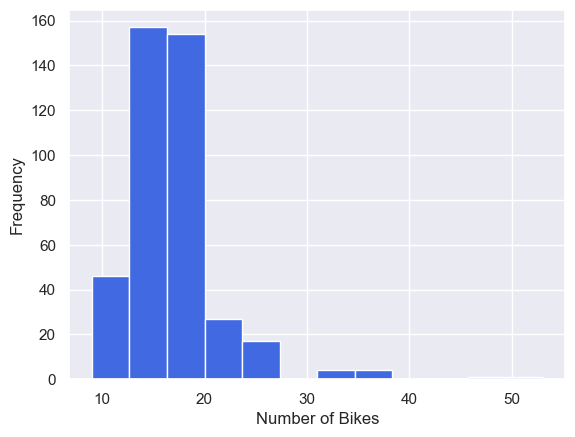

In [154]:
stations_model['Number of Bikes'].plot.hist(bins=12, color='royalblue')
plt.xlabel('Number of Bikes')
plt.savefig('../images/bikes_distribution.png', bbox_inches='tight')

**Analysis**: The values for Number of Bikes are mostly between 10 and 30, with a few outliers above 40. 

Most of the stations (>300) have an average number of bikes between 15-20, and this could be the result of a company standard, since they're all Blue Bike stations.  Perhaps the stations with fewer or more bikes were tailored to the population density or the availability of biking spaces for those specific regions. A map analysis will provide more information.

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Restaurants')

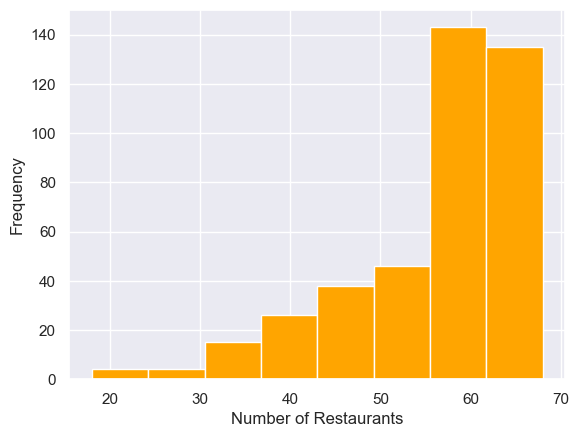

In [155]:
stations_model['Number of Restaurants'].plot.hist(bins=8, color='orange')
plt.xlabel('Number of Restaurants')

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Number of Restaurants')

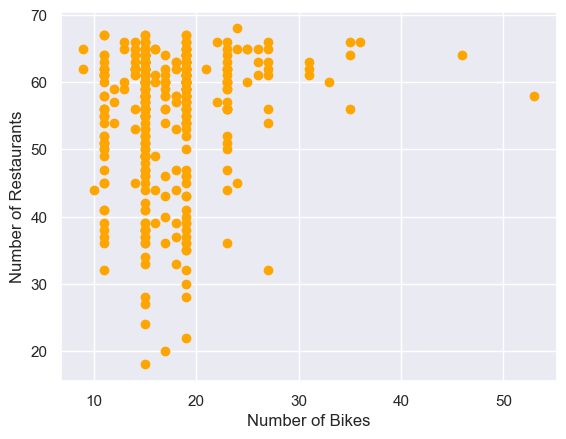

In [156]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Number of Restaurants'], color='orange')
plt.xlabel ('Number of Bikes')
plt.ylabel ('Number of Restaurants')

**Analysis**: From the histogram, the distribution of the Number of Restaurants skews to the left. There are more Restaurants within stations. 

The scatter plot shows no correlation between these values. The number of restaurants does not seem to be affected by the size of the neigbouring bike stations. 

<Axes: ylabel='Frequency'>

Text(0.5, 0, 'Number of Rentals')

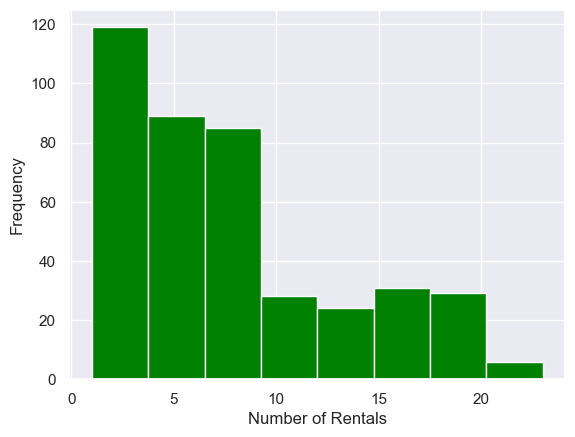

In [157]:
stations_model['Number of Rentals'].plot.hist(bins=8, color='green')
plt.xlabel('Number of Rentals')

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Number of Rentals')

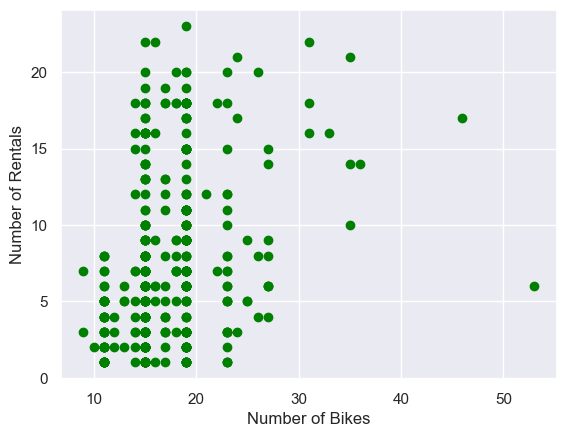

In [158]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Number of Rentals'], color='green')
plt.xlabel ('Number of Bikes')
plt.ylabel ('Number of Rentals')

**Analysis**: From the histogram, the Number of Rentals skews to the right. The scatter plot shows no clear relationship between the Number of Bikes and the Number of Rentals.

<Axes: ylabel='Frequency'>

<Axes: ylabel='Frequency'>

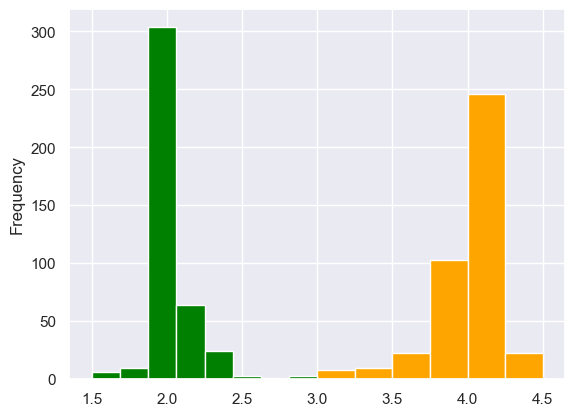

In [159]:
stations_model['Average Restaurant Rating'].plot.hist(bins=8, color='orange', label='Restaurant')
# plt.xlabel('Average Rating')

stations_model['Average Rental Rating'].plot.hist(bins=8, color='green', label='Rental')
# plt.xlabel('Average  Rating')
plt.title = 'Average Rating'

plt.savefig('../images/histogram_of_ratings.png', bbox_inches='tight')

**Observation**: Restaurants are generally rated higher than Car Rentals which is around average/below average. 

Text(0.5, 0, 'Number of Bikes')

Text(0, 0.5, 'Rating')

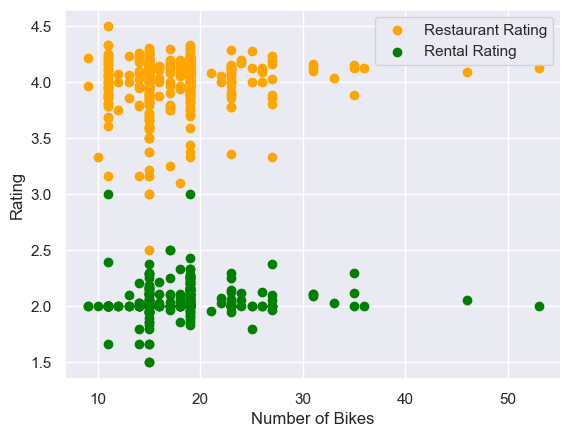

In [160]:
plt.scatter(stations_model['Number of Bikes'], stations_model['Average Restaurant Rating'], 
            color='orange',
            label='Restaurant Rating')

plt.xlabel ('Number of Bikes')

plt.scatter(stations_model['Number of Bikes'], stations_model['Average Rental Rating'], 
            color='green',
            label='Rental Rating')
plt.legend(loc = 'upper right')
plt.ylabel('Rating')

plt.title = 'Distribution of Ratings of Places of Interests with Bike stations'

**Analysis**: The scatter plot shows no correlation between these values and Nunber of Bikes. The rating of places does not seem to be affected by the size of the neigbouring bike stations. The distribution of this data is similar to the histogram above, showing how little of an impact that the number of Bikes made to the Ratings distributions.

Text(0.5, 0, 'Number of Bikes')

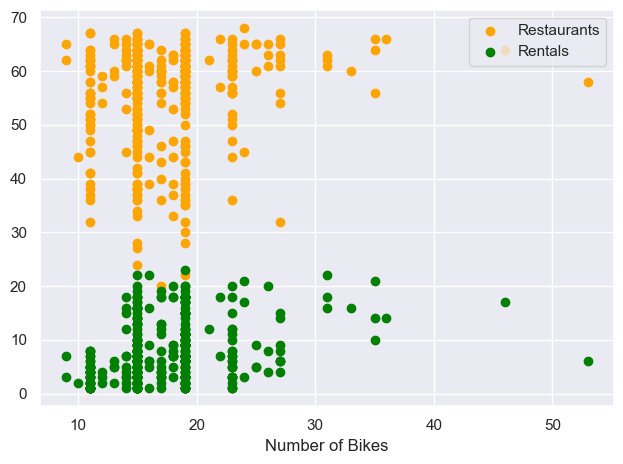

In [161]:
plt.scatter(stations_model['Number of Bikes'], 
            stations_model['Number of Restaurants'],
            marker='o',
            color='orange',
            label='Restaurants')

plt.scatter(stations_model['Number of Bikes'], 
            stations_model['Number of Rentals'],
            marker='o',
            color='green',
            label='Rentals')
plt.legend(loc = 'upper right')
plt.xlabel('Number of Bikes')

plt.title = 'Distribution of Places of Interests with Bike stations'
plt.tight_layout()

**Analysis**: This shows little to no correlation between the number of restaurants and rentals to the number of bikes. But it looks like there's a pattern between the Number of Restaurants and the Number of Car rentals, and their respective ratings. It will be worth exploring the relationship between the promotion of biking versus interest in food/food business versus the interest or willingness to rent motor vehicles.

Summary of Prelimary Analysis:

    1. Skewed distributions of all the values.
    2. No clear correlation between places of interests, their ratings and the number of bikes.
    3. Extreme outliers for all the values which will be dealt with during model building

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Preamble:
    To create a good Database, we need to 3 distinct tables with non-duplicating information:
    
        1. `stations` - a table of stations with their ID, longitude and latitude, and number of bikes.
        2. `places` - a table of places of interest with their unique names, IDs, ratings and review counts.
        3. `stations_places` - a table showing the relationships between the stations and the nearby places of interests.
        

### 1.` stations`
The table `stations_df` already exists with most of these requirements. We just need to:
- create a separate "index" column for the SQLite database to recognize as its primary key. (the original Station ID from citybikes will not be used for the database).
- removing the information about number of restaurants, etc, and just keep information unique to the station.

In [140]:
# importing the stations_df table
stations_df = pd.read_csv('../data/stations_df.csv')
stations_df.columns

Index(['Station Name', 'Latitude', 'Longitude', 'Number of Bikes',
       'Station ID'],
      dtype='object')

In [141]:
stations = stations_df[['Station Name', 'Latitude', 'Longitude', 'Number of Bikes']].copy()
stations['ID'] = stations.index # add column index
stations = stations[['ID', 'Station Name', 'Latitude', 'Longitude', 'Number of Bikes']] # rearranging columns
stations.head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


### 2. `places`

- use `groupby` to aggregate the average Review Count and Ratings of each Place.

In [142]:
points_of_interest.head()

,Name,Review Count,Ratings,Bike Station Id,Category
0,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,New Saigon,201,4.5,0,Restaurant
3,Melodias,12,4.0,0,Restaurant
4,Renegade's Pub,126,4.0,0,Restaurant


In [143]:
# aggregating the averages of review count and rating
places = points_of_interest.groupby('Name').\
    agg({'Review Count': 'mean', 'Ratings': 'mean', 'Category': 'first'}).copy()
places['Review Count'] = round(places['Review Count']).astype(int) # keeping this an integer value
places

,Review Count,Ratings,Category
Name,,,
100% Delicias,46,1.500000,Restaurant
100% Delicias Express,7,4.000000,Restaurant
110 Grill,63,3.727273,Restaurant
110 Grill South Bay,0,4.000000,Restaurant
1260 Boylston,0,4.000000,Restaurant
...,...,...,...
Zumes Cafe House,0,4.000000,Restaurant
Zuru Zuru,0,4.000000,Restaurant
Zuru Zuru Ramen And Donburi,118,4.500000,Restaurant


In [144]:
# confirm by counting the unique names of the table
points_of_interest['Name'].nunique()

4152

In [145]:
# reindexing: 
    # reseting the index
places.reset_index(inplace=True)
# adding column index to be the primary key in the database
places['ID'] = places.index # add column index
places = places[['ID', 'Name', 'Review Count', 'Ratings', 'Category']] # rearranging columns
places['Ratings'] = places['Ratings'].round(2)
places

,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant
...,...,...,...,...,...
4147,4147,Zumes Cafe House,0,4.00,Restaurant
4148,4148,Zuru Zuru,0,4.00,Restaurant
4149,4149,Zuru Zuru Ramen And Donburi,118,4.50,Restaurant
4150,4150,Zuzu,0,4.00,Restaurant


### 3. `stations_places`


In [146]:
# use the newly created table places to add a places index to stations_and_places
stations_and_places.head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant


In [ ]:
# run through each row in the joined table to collect EVERY combination of places and stations
stations_and_places['Place ID'] = 0
for idx in stations_and_places.index:
    print(idx)
#     break
    placename = stations_and_places.loc[idx, 'Name']
    index_in_places = places[places['Name'] == placename].index.values[0]
    stations_and_places.loc[idx, 'Place ID'] = index_in_places

In [148]:
stations_and_places.head()

,Station Name,Latitude,Longitude,Number of Bikes,Station ID,Name,Review Count,Ratings,Bike Station Id,Category,Place ID
0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Luna's Restaurant Italian And Latin Cuisine,122,4.5,0,Restaurant,2157
1,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Angela's Cafe - Orient Heights,136,4.5,0,Restaurant,151
2,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,New Saigon,201,4.5,0,Restaurant,2489
3,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Melodias,12,4.0,0,Restaurant,2291
4,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19,553ed0300d38108b4f21a6bafa3db70c,Renegade's Pub,126,4.0,0,Restaurant,2981


In [149]:
#inspecting
stations_and_places.groupby(['Bike Station Id', 'Place ID']).size().to_frame()

0
Bike Station Id Place ID   
0               71        1
                151       1
                152       1
                229       1
                528       1
...                      ..
442             4080      1
                4105      1
                4110      1
                4119      1
                4122      1

[27210 rows x 1 columns]

In [150]:
# use groupby to get UNIQUE combinations of placeID and stationID
stations_places = stations_and_places.groupby(['Bike Station Id', 'Place ID']).size().reset_index().copy()
stations_places.drop(columns=0, axis=1, inplace=True) # drop the 0 count column
stations_places.rename(columns={'Bike Station Id':'Station ID'}, inplace=True)
stations_places

,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528
...,...,...
27205,442,4080
27206,442,4105
27207,442,4110
27208,442,4119


* Now that the 3 tables are complete, we can now create the SQLite Database.
* Before then, we'll save these dataframes and confirm that it was saved properly

In [151]:
stations.to_csv('../data/stations.csv', index=False)
places.to_csv('../data/places.csv', index=False)
stations_places.to_csv('../data/stations_places.csv', index=False)

In [152]:
pd.read_csv('../data/stations.csv').head()
pd.read_csv('../data/places.csv').head()
pd.read_csv('../data/stations_places.csv').head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant


,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528


# Creating the Database

In [56]:
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine
from sqlalchemy import URL
from sqlalchemy import text

### Connecting to the database

In [57]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection("../data/citybikes.sqlite")

Connection to SQLite DB successful


In [58]:

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [59]:
## Inspecting our tables one more time before uploading them
stations.head()
places.head()
stations_places.head()

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15


,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant


,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528


In [62]:
# drop_table = '''
# DROP TABLE places;'''

# execute_query(connection, drop_table) 

Query executed successfully


### Creating the tables

In [63]:
create_stations_table = """

CREATE TABLE stations (
    'ID' INT NOT NULL PRIMARY KEY,
    'Station Name' TEXT NOT NULL,
    'Latitude' REAL NOT NULL,
    'Longitude' REAL NOT NULL,
    'Number of Bikes' INT
);
"""
execute_query(connection, create_stations_table) 

Query executed successfully


In [64]:
create_places_table = """
CREATE TABLE places (
    'ID' INT NOT NULL PRIMARY KEY,
    'Name' TEXT NOT NULL,  
    'Review Count' INT,
    'Ratings' REAL,
    'Category' TEXT
);
"""
execute_query(connection, create_places_table) 

Query executed successfully


In [65]:
create_stations_places_table = """
CREATE TABLE stations_and_places (
    'Station ID' INT,
    'Place ID' INT, 
    PRIMARY KEY ('Station ID', 'Place ID'),
    FOREIGN KEY('Station ID') REFERENCES stations('ID'),
    FOREIGN KEY('Place ID') REFERENCES places('ID')
    
);
"""
execute_query(connection, create_stations_places_table) 

Query executed successfully


In [66]:
connection.close() # close the connection for now

### Updating the tables with SQLAlchemy

* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html


In [67]:
# Creating Connection
engine = create_engine('sqlite:///../data/citybikes.sqlite') # database driver /// database
engine.connect()

In [68]:
# Update values into stations table
stations.to_sql('stations', index=False, con=engine, if_exists='append')

443

In [69]:
# Update values into places table
places.to_sql('places', index=False, con=engine, if_exists='append')

4152

In [70]:
# Update values into stations_places table
stations_places.to_sql('stations_and_places', index=False, con=engine, if_exists='append')

27210

In [71]:
engine.dispose() # close connection 

## Validating the database.
The records will be retrieved from the database and stored into dataframes and run equality check against the existing dataframes. 


### stations

In [72]:
sql = """SELECT * FROM stations;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,ID,Station Name,Latitude,Longitude,Number of Bikes
0,0,Orient Heights T Stop - Bennington St at Sarat...,42.386781,-71.006098,19
1,1,Maverick Square - Lewis Mall,42.368844,-71.039778,33
2,2,East Boston Neighborhood Health Center - 20 Ma...,42.369536,-71.039431,16
3,3,Bennington St at Byron St,42.383533,-71.016191,15
4,4,Boston East - 126 Border St,42.373312,-71.041020,15
...,...,...,...,...,...
438,438,Central Ave at River St,42.270947,-71.073379,15
439,439,1200 Beacon St,42.344149,-71.114674,15
440,440,Newbury St at Hereford St,42.348717,-71.085954,22
441,441,Boylston St at Dartmouth St,42.350193,-71.077442,19


In [73]:
(df == stations).value_counts() # all True confirming that they're identical

ID    Station Name  Latitude  Longitude  Number of Bikes
True  True          True      True       True               443
dtype: int64

### places

In [74]:
sql = """SELECT * FROM places;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,ID,Name,Review Count,Ratings,Category
0,0,100% Delicias,46,1.50,Restaurant
1,1,100% Delicias Express,7,4.00,Restaurant
2,2,110 Grill,63,3.73,Restaurant
3,3,110 Grill South Bay,0,4.00,Restaurant
4,4,1260 Boylston,0,4.00,Restaurant
...,...,...,...,...,...
4147,4147,Zumes Cafe House,0,4.00,Restaurant
4148,4148,Zuru Zuru,0,4.00,Restaurant
4149,4149,Zuru Zuru Ramen And Donburi,118,4.50,Restaurant
4150,4150,Zuzu,0,4.00,Restaurant


In [75]:
(df == places).value_counts() # all True confirming that they're identical

ID    Name  Review Count  Ratings  Category
True  True  True          True     True        4152
dtype: int64

### stations_places

In [76]:
sql = """SELECT * FROM stations_and_places;"""

with create_engine('sqlite:///../data/citybikes.sqlite').connect() as con:
    df = pd.read_sql_query(text(sql), con)
df

,Station ID,Place ID
0,0,71
1,0,151
2,0,152
3,0,229
4,0,528
...,...,...
27205,442,4080
27206,442,4105
27207,442,4110
27208,442,4119


In [77]:
(df == stations_places).value_counts() # all True confirming that they're identical

Station ID  Place ID
True        True        27210
dtype: int64